In [1]:
# use dream_proj_env3
import pandas as pd
import scanpy as sc
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy.stats import mannwhitneyu, spearmanr, pearsonr
import numpy as np
import anndata as ad
import colorcet as cc
from pylr2 import regress2


# auto reload source files
%load_ext autoreload
%autoreload 2
# add source directory to path
source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
# read source files–––
import read_data
from expr_dataset import ExpressionDataset
from meta_expr_dataset import MetaExpressionDataset
from sc_expr_dataset import ScExpressionDataset
import utils
# colorpalettes 
hmm = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
fred_again_again_again_palette = ['#000305', '#ff7758', '#f67805', '#d3d3d3', '#565656', '#054fff', '#f9aa74', '#5890ff']
sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693','#a059a0','#5c53a5']
magma_categorical = plt.cm.get_cmap('magma', 10)
my_continous_palette = sunset
my_categorical_palette = []
my_categorical_palette.append(hmm[3])
my_categorical_palette.append(fred_again_again_again_palette[-2])
my_categorical_palette.append(hmm[-1])
my_categorical_palette.append(fred_again_again_again_palette[-1])

my_categorical_palette.append(hmm[2])
my_categorical_palette.append(sunset[-1])
my_categorical_palette.append(sunset[-2])
my_categorical_palette.append(sunset[-5])
my_categorical_palette.append(sunset[-7])

%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/tmp/ipykernel_904211/2889465995.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma_categorical = plt.cm.get_cmap('magma', 10)


# Read & combine data

In [7]:
ts.dream_expression

AnnData object with n_obs × n_vars = 412848 × 321
    obs: 'tissue', 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue_specific', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'age', 'n_counts', 'mean_dream_activity', 'mean_dream_activity_resid', 'DREAM_enrichment_score', 'DREAM_normalized_enrichment_score', 'DREAM_normalized_enrichment_score_resid', 'DREAM_enrichment_score_resid', 'mutation_burden', 'CB', 'sc_mutation_burden', 'sc_mutation_burden_in_bulk', 'SitesPerCell', 'callable_sites', 'mutation_burden_per_kb', 

In [ ]:
loader = read_data.DatasetLoader(dataset_name = 'tabula_sapiens')
ts = loader.load_dataset()

# remove cells which are form Heart, Mammary, Pances, and Uterus which we did not call mutations from
tissues_to_remove = ['Heart', 'Mammary', 'Pancreas', 'Uterus', 'Eye']
mask = ~ts.dream_expression.obs['tissue'].isin(tissues_to_remove)
#ts.dream_expression = ts.dream_expression[mask, :]

# Fix index type before subsetting
ts.dream_expression.obs_names_make_unique()
ts.dream_expression.obs.index = ts.dream_expression.obs.index.astype(str)
ts.dream_expression = ts.dream_expression[mask, :]

# create nanfilled mutation burden columns
ts.dream_expression.obs['mutation_burden_per_genome_nanfilled'] = ts.dream_expression.obs['mutation_burden_per_genome'].fillna(0)
ts.dream_expression.obs['sc_mutation_burden_per_genome_nanfilled'] = ts.dream_expression.obs['sc_mutation_burden_per_genome'].fillna(0)
ts.dream_expression.obs['sc_mutation_burden_in_bulk_per_genome_nanfilled'] = ts.dream_expression.obs['sc_mutation_burden_in_bulk_per_genome'].fillna(0)
ts.dream_expression.obs['mutation_burden_per_kb_nanfilled'] = ts.dream_expression.obs['mutation_burden_per_kb'].fillna(0)
ts.dream_expression.obs['sc_mutation_burden_per_kb_nanfilled'] = ts.dream_expression.obs['sc_mutation_burden_per_kb'].fillna(0)
ts.dream_expression.obs['sc_mutation_burden_in_bulk_per_kb_nanfilled'] = ts.dream_expression.obs['sc_mutation_burden_in_bulk_per_kb'].fillna(0)

/cellar/users/zkoch/miniconda3/envs/dream_proj_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:841: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/tmp/ipykernel_904211/757579690.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ts.dream_expression.obs['mutation_burden_per_genome_nanfilled'] = ts.dream_expression.obs['mutation_burden_per_genome'].fillna(0)


In [17]:
# takes 10 minutes
loader = read_data.DatasetLoader('SEA-AD')
sea_ad = loader.load_dataset()

sea_ad.adata.obs['Subclass'] = sea_ad.adata.obs['Subclass'].str.replace(' ', '_')
sea_ad.adata.obs['Subclass'] = sea_ad.adata.obs['Subclass'].str.replace('/', '_')
sea_ad.dream_expression.obs['Subclass'] = sea_ad.dream_expression.obs['Subclass'].str.replace(' ', '_')
sea_ad.dream_expression.obs['Subclass'] = sea_ad.dream_expression.obs['Subclass'].str.replace('/', '_')

# add lineage to slope_df
# color map
CELL_TYPE_LINEAGES = {
    'Endothelial': 'Other',       # Other
    'L2_3_IT': 'Neuronal',          # Neuronal
    'Sst_Chodl': 'Neuronal',        # Neuronal
    'VLMC': 'Other',              # Other
    'L5_IT': 'Neuronal',            # Neuronal
    'Astrocyte': 'Glial',       # Glial
    'Pvalb': 'Neuronal',            # Neuronal
    'Oligodendrocyte': 'Glial', # Glial
    'L6_IT': 'Neuronal',            # Neuronal
    'L4_IT': 'Neuronal',            # Neuronal
    'L5_ET': 'Neuronal',            # Neuronal
    'Vip': 'Neuronal',              # Neuronal
    'OPC': 'Glial',             # Glial
    'L6b': 'Neuronal',              # Neuronal
    'L6_IT_Car3': 'Neuronal',       # Neuronal
    'Microglia-PVM': 'Glial',   # Glial
    'Pax6': 'Neuronal',             # Neuronal
    'Sst': 'Neuronal',              # Neuronal
    'L6_CT': 'Neuronal',            # Neuronal
    'Chandelier': 'Neuronal',       # Neuronal
    'Lamp5': 'Neuronal',            # Neuronal
    'L5_6_NP': 'Neuronal',          # Neuronal
    'Lamp5_Lhx6': 'Neuronal',       # Neuronal
    'Sncg': 'Neuronal'              # Neuronal
}
sea_ad.dream_expression.obs['lineage'] = sea_ad.dream_expression.obs['Subclass'].map(CELL_TYPE_LINEAGES)

# mutation burden scaled to per genome
sea_ad.dream_expression.obs['sc_mutation_burden_per_genome'] = 3e9 * (sea_ad.dream_expression.obs['sc_mutation_burden'] / (sea_ad.dream_expression.obs['SitesPerCell']))
sea_ad.dream_expression.obs['mutation_burden_per_genome'] = 3e9 * (sea_ad.dream_expression.obs['mutation_burden'] / (sea_ad.dream_expression.obs['callable_sites']))
# create nanfilled mutation burden columns
sea_ad.dream_expression.obs['mutation_burden_per_genome_nanfilled'] = sea_ad.dream_expression.obs['mutation_burden_per_genome'].fillna(0)
sea_ad.dream_expression.obs['sc_mutation_burden_per_genome_nanfilled'] = sea_ad.dream_expression.obs['sc_mutation_burden_per_genome'].fillna(0)
sea_ad.dream_expression.obs['sc_mutation_burden_in_bulk_per_genome_nanfilled'] = sea_ad.dream_expression.obs['sc_mutation_burden_in_bulk_per_genome'].fillna(0)
sea_ad.dream_expression.obs['mutation_burden_per_kb_nanfilled'] = sea_ad.dream_expression.obs['mutation_burden_per_kb'].fillna(0)
sea_ad.dream_expression.obs['sc_mutation_burden_per_kb_nanfilled'] = sea_ad.dream_expression.obs['sc_mutation_burden_per_kb'].fillna(0)
sea_ad.dream_expression.obs['sc_mutation_burden_in_bulk_per_kb_nanfilled'] = sea_ad.dream_expression.obs['sc_mutation_burden_in_bulk_per_kb'].fillna(0)

Loading dataset: SEA-AD
using new dream file:  False
Found 306 DREAM genes with expression
Reading in mutations


/cellar/users/zkoch/miniconda3/envs/dream_proj_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Reading in callable sites


/cellar/users/zkoch/miniconda3/envs/dream_proj_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Reading in sc genotypes


/cellar/users/zkoch/miniconda3/envs/dream_proj_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/cellar/users/zkoch/miniconda3/envs/dream_proj_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Reading in sc callable sites


/cellar/users/zkoch/miniconda3/envs/dream_proj_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [17]:
ts_sea.dream_expression.obs['mutation_burden_nanfilled'] = ts_sea.dream_expression.obs['mutation_burden'].fillna(0)

In [19]:
ts_sea.dream_expression.obs.groupby('tissue')[['mutation_burden', 'mutation_burden_nanfilled']].mean().sort_values(by='mutation_burden', ascending=False)

,mutation_burden,mutation_burden_nanfilled
tissue,,
Brain,633.829458,625.630919
Muscle,569.585569,556.799090
Lymph_Node,354.097794,246.552854
Tongue,351.984594,341.989875
Fat,326.132184,326.082297
Blood,242.278992,206.755501
Bone_Marrow,225.674547,158.258909
Thymus,199.105470,104.246542
Kidney,190.445583,16.043361


In [4]:
# rename to match between datasets
sea_ad.dream_expression.obs.rename(columns = {'Subclass': 'cell_type', 'Donor ID': 'donor_id', 'Age at Death': 'age'}, inplace = True)
sea_ad.dream_expression.obs['tissue'] = 'Brain'
# combine the datasets 
concated_dream_expression = ad.concat([ts.dream_expression, sea_ad.dream_expression], axis = 0, join = 'outer', label = 'dataset', keys = ['ts', 'sea_ad'])
# create sc_expr_dataset of combined dataset
ts_sea = ScExpressionDataset(concated_dream_expression, 'human', 'ts_sea')
ts_sea.dream_expression = concated_dream_expression
ts_sea.dream_expression.obs.reset_index(inplace = True, drop = True)
ts_sea.dream_expression.obs['sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year'] = ts_sea.dream_expression.obs['sc_mutation_burden_in_bulk_per_genome_nanfilled'] / ts_sea.dream_expression.obs['age']
# remove the samples with 
neuronal_cell_types = [k for k, v in CELL_TYPE_LINEAGES.items() if v == 'Neuronal']

/cellar/users/zkoch/miniconda3/envs/dream_proj_env/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/cellar/users/zkoch/miniconda3/envs/dream_proj_env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/cellar/users/zkoch/miniconda3/envs/dream_proj_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
mut_col = 'sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year'
dream_col = 'DREAM_normalized_enrichment_score_resid'

# ensure there are >=2 samples per tissue, >=500 cells per tissue, and >=1e5 callable sites per cell
cells_per = ts_sea.dream_expression.obs.query("SitesPerCell >= 1e5").dropna(subset = [mut_col])['tissue'].value_counts()
samples_per = ts_sea.dream_expression.obs.query("SitesPerCell >= 1e5").dropna(subset = [mut_col]).groupby('tissue')['donor_id'].nunique().sort_values(ascending = False)
cells_per = cells_per[cells_per >= 500]
samples_per = samples_per[samples_per >= 2]
to_use = set(cells_per.index.tolist()) & set(samples_per.index.tolist())


# donors with enough cell types to be relevant
#donors_to_use = ['TSP1', 'TSP2', 'TSP7','TSP14'] #['TSP2','TSP14']#
subset = "SitesPerCell >= 1e5 and tissue in @to_use" #and donor_id in @donors_to_use"

In [17]:
ts_sea.dream_expression.obs.query(subset)['sc_mutation_burden_in_bulk_per_genome_nanfilled'].describe()


count    830238.000000
mean        829.057136
std        2346.082623
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      720858.622715
Name: sc_mutation_burden_in_bulk_per_genome_nanfilled, dtype: float64

In [18]:
ts_sea.dream_expression.obs.query(subset)['sc_mutation_burden_in_bulk'].describe()


count    206312.000000
mean          1.876415
std           1.550428
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          27.000000
Name: sc_mutation_burden_in_bulk, dtype: float64

# C) Mutation burden per year

/tmp/ipykernel_1756058/4175600999.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burden_df.dropna(subset=[mutation_column, age_column], inplace=True)


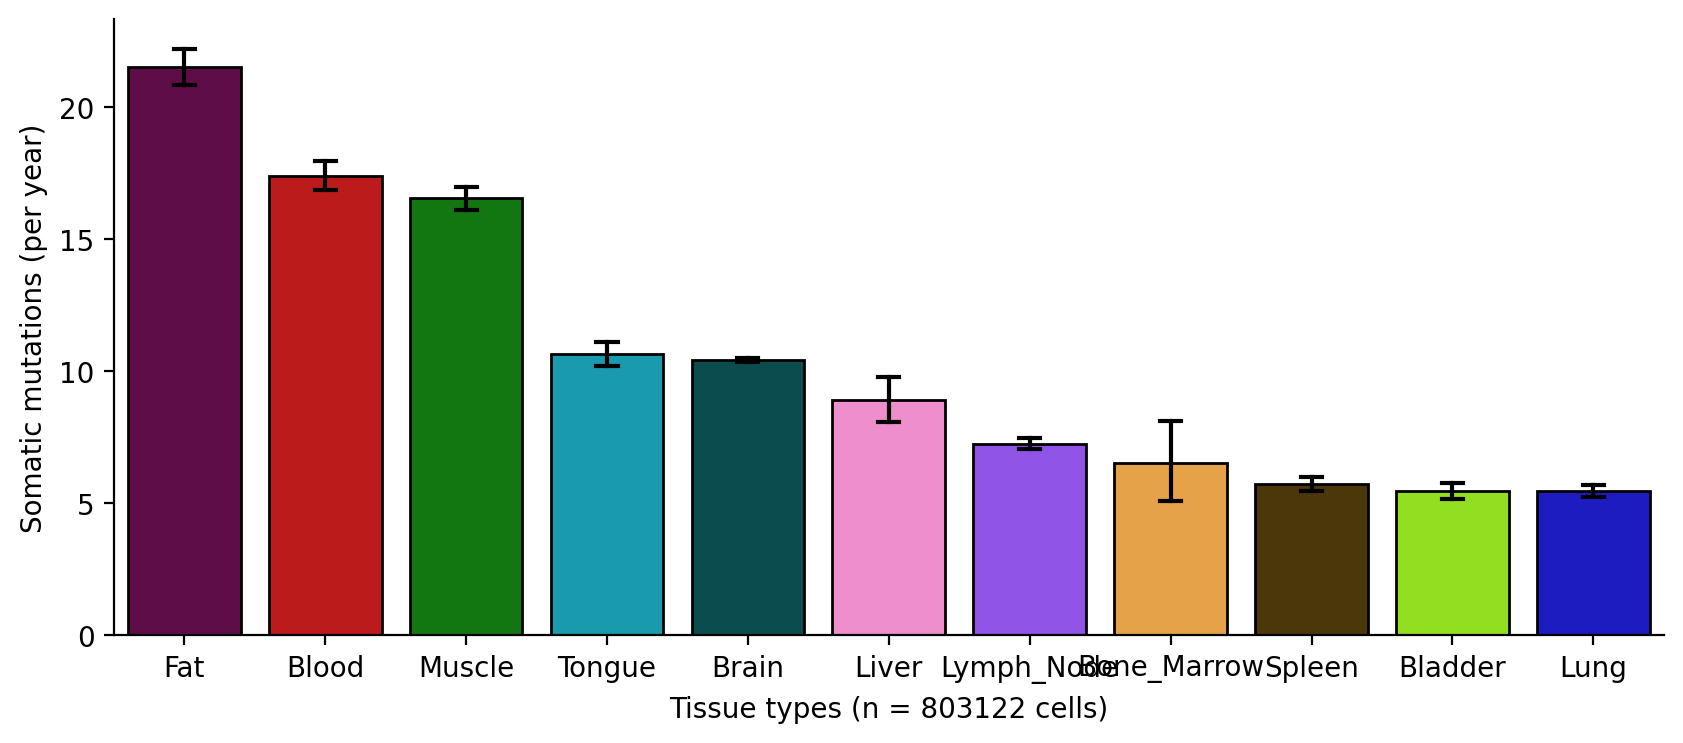

In [287]:
callable_sites_col = 'SitesPerCell'
mutation_column = 'sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year'
age_column = 'age'
cell_type_column = 'tissue'
min_callable_sites = 1e5
min_cell_per_subclass = 100

burden_df = ts_sea.dream_expression.obs.query(f"{callable_sites_col} >= @min_callable_sites")
burden_df.dropna(subset=[mutation_column, age_column], inplace=True)

# Filter celltypes with too few cells
ct_counts = burden_df.query(f"{mutation_column} > 0")[cell_type_column].value_counts()
celltypes_to_keep = ct_counts[ct_counts >= min_cell_per_subclass].index
burden_df = burden_df.loc[burden_df[cell_type_column].isin(celltypes_to_keep)]

fig, axes = plt.subplots(1,1, figsize = (10,4))  
order = burden_df.groupby(cell_type_column)[mutation_column].mean().sort_values(ascending = False).index
# create palette mapping from tissue to cc.glasbey
# Create mapping from tissue to first len(tissues) colors from cc.glasbey
tissue_colors = {tissue: cc.glasbey[i] for i, tissue in enumerate(order)}
# switch colors of bladder and brain
bladder = tissue_colors['Bladder']  
tissue_colors['Bladder'] = tissue_colors['Brain']
tissue_colors['Brain'] = bladder
# switch colors of fat and blood
fat = tissue_colors['Fat']
tissue_colors['Fat'] = tissue_colors['Blood']
tissue_colors['Blood'] = fat
# switch colors of fat and Lymph_Node
fat = tissue_colors['Fat']
tissue_colors['Fat'] = tissue_colors['Lymph_Node']
tissue_colors['Lymph_Node'] = fat
# switch Liver and Bone_Marrow
sns.barplot(
    data = burden_df, x = cell_type_column, y = mutation_column, order = order,
    ax = axes, capsize = 0.15, palette = tissue_colors,
    err_kws = {'color': 'black', 'linewidth': 1.5}, hue = cell_type_column, legend = False,
    edgecolor = 'black', errorbar = ('ci', 95)
    )
sns.despine()
axes.set_ylabel('Somatic mutations (per year)')
axes.set_xlabel(f'Tissue types (n = {len(burden_df)} cells)')

# save as svg
plt.savefig('/cellar/users/zkoch/dream/figures/fig_human_mut/mutation_burden_per_year_by_tissue.svg', format='svg', dpi=300)

# B) Example mutation scatterplot

In [5]:
regr_df = ts_sea.dream_expression.obs.query("SitesPerCell >= 1e5")
# filter out subclasses with less than min_cell_per_subclass cells
subclass_counts = regr_df['cell_type'].value_counts()
subclasses_to_keep = subclass_counts[subclass_counts >= 100].index
regr_df = regr_df.loc[regr_df['cell_type'].isin(subclasses_to_keep)]

In [33]:
regr_df.query("tissue == 'Brain' and donor_id in @donors_to_use")#['donor_id'].value_counts().hist()

,tissue,assay_ontology_term_id,donor_id,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,...,Class,Subclass confidence,Supertype confidence,Supertype (non-expanded),Supertype,Severely Affected Donor,mut_sample_id,lineage,dataset,sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year
361255,Brain,NaN,H20.33.013,NaN,NaN,2484,NaN,NaN,<NA>,NaN,...,Neuronal: Glutamatergic,1.0,1.000000,L2/3 IT_1,L2/3 IT_1,N,1109152712,Neuronal,sea_ad,0.000000
361256,Brain,NaN,H21.33.040,NaN,NaN,8902,NaN,NaN,<NA>,NaN,...,Neuronal: Glutamatergic,1.0,0.962663,L2/3 IT_6,L2/3 IT_6,N,1131593671,Neuronal,sea_ad,0.000000
361258,Brain,NaN,H21.33.004,NaN,NaN,8118,NaN,NaN,<NA>,NaN,...,Neuronal: GABAergic,1.0,0.999901,Vip_11,Vip_11,N,1128419128,Neuronal,sea_ad,0.000000
361260,Brain,NaN,H21.33.006,NaN,NaN,2127,NaN,NaN,<NA>,NaN,...,Non-neuronal and Non-neural,1.0,0.808123,Oligo_2,Oligo_2,N,1114947894,Glial,sea_ad,0.000000
361264,Brain,NaN,H20.33.034,NaN,NaN,1754,NaN,NaN,<NA>,NaN,...,Neuronal: GABAergic,1.0,0.999845,Vip_4,Vip_4,N,1132961567,Neuronal,sea_ad,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756846,Brain,NaN,H21.33.018,NaN,NaN,7457,NaN,NaN,<NA>,NaN,...,Neuronal: Glutamatergic,1.0,1.000000,L4 IT_2,L4 IT_2,N,1124416551,Neuronal,sea_ad,0.000000
1756847,Brain,NaN,H21.33.014,NaN,NaN,1854,NaN,NaN,<NA>,NaN,...,Non-neuronal and Non-neural,1.0,1.000000,Oligo_4,Oligo_4,N,1134006384,Glial,sea_ad,130.472881
1756848,Brain,NaN,H21.33.011,NaN,NaN,10667,NaN,NaN,<NA>,NaN,...,Neuronal: Glutamatergic,1.0,0.999162,L5 IT_7,L5 IT_7,N,1134004938,Neuronal,sea_ad,5.710694
1756849,Brain,NaN,H21.33.019,NaN,NaN,6367,NaN,NaN,<NA>,NaN,...,Neuronal: GABAergic,1.0,1.000000,Sst_3,Sst_3,N,1127603900,Neuronal,sea_ad,0.000000


In [34]:
tissue_colors['Brain']

'#005659'

/tmp/ipykernel_1869163/864204485.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(


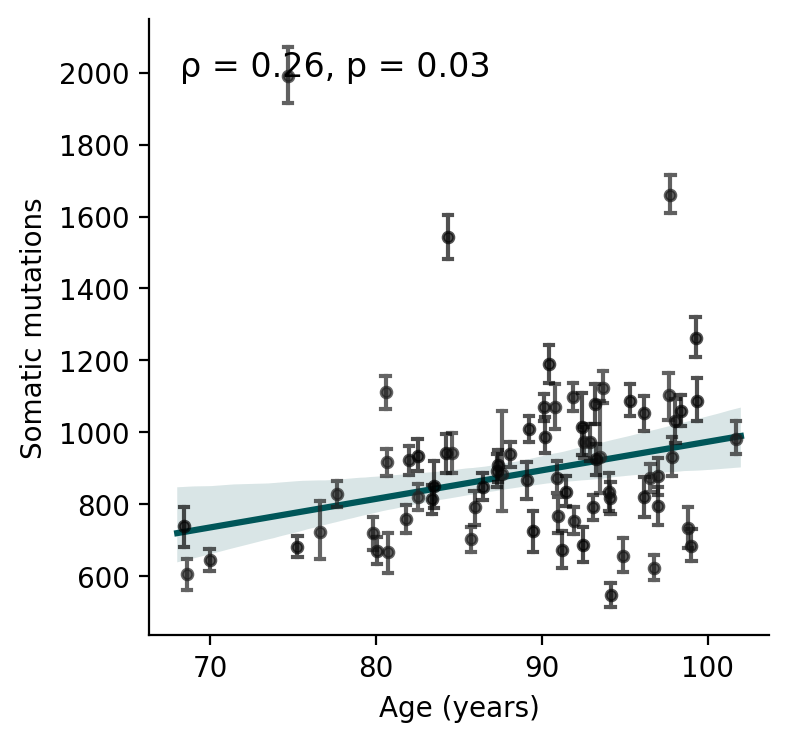

In [22]:
fig, axes = plt.subplots(1,1, figsize = (4, 4))
# use only donors with at least 5000 cells
cells_per_donor = regr_df.query("tissue == 'Brain'")['donor_id'].value_counts()
donors_to_use = cells_per_donor[cells_per_donor >= 5000].index

mean_df = regr_df.query("tissue == 'Brain' and donor_id in @donors_to_use").groupby('donor_id')[['age', 'sc_mutation_burden_in_bulk_per_genome_nanfilled']].mean().reset_index()
sns.regplot( 
    data = mean_df, x = 'age', y = 'sc_mutation_burden_in_bulk_per_genome_nanfilled', 
    ax = axes, color = tissue_colors['Brain'], scatter = False, robust = True, 
    )

sns.pointplot(
    data = regr_df.query("tissue == 'Brain' and donor_id in @donors_to_use"), x = 'age', y = 'sc_mutation_burden_in_bulk_per_genome_nanfilled', hue = 'donor_id',
    native_scale = True, linestyles = 'none', ax = axes,
    color = 'black', linewidth = 1.5, capsize = 0.5, legend = False, dodge = 1, alpha = 0.7
    )

rho, p = spearmanr(mean_df.dropna(subset = ['age', 'sc_mutation_burden_in_bulk_per_genome_nanfilled'])['age'], mean_df.dropna(subset = ['age', 'sc_mutation_burden_in_bulk_per_genome_nanfilled'])['sc_mutation_burden_in_bulk_per_genome_nanfilled'])
# add rho and p to axes
axes.text(0.05, 0.95, f'ρ = {rho:.2f}, p = {p:.2f}', transform=axes.transAxes, fontsize=12, verticalalignment='top')

axes.set_ylabel('Somatic mutations')
axes.set_xlabel('Age (years)')
sns.despine()
# save as svg
plt.savefig('/cellar/users/zkoch/dream/figures/fig_human_mut/brain_scatter_mutation_burden_by_age.svg', format='svg', dpi=300)


# D) Mutation burden vs. DREAM activity

/tmp/ipykernel_1756058/82848543.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = ts_sea.dream_expression.obs.query(subset).groupby(['tissue', 'dream_activity_bin'])[mut_col].mean().sort_values(


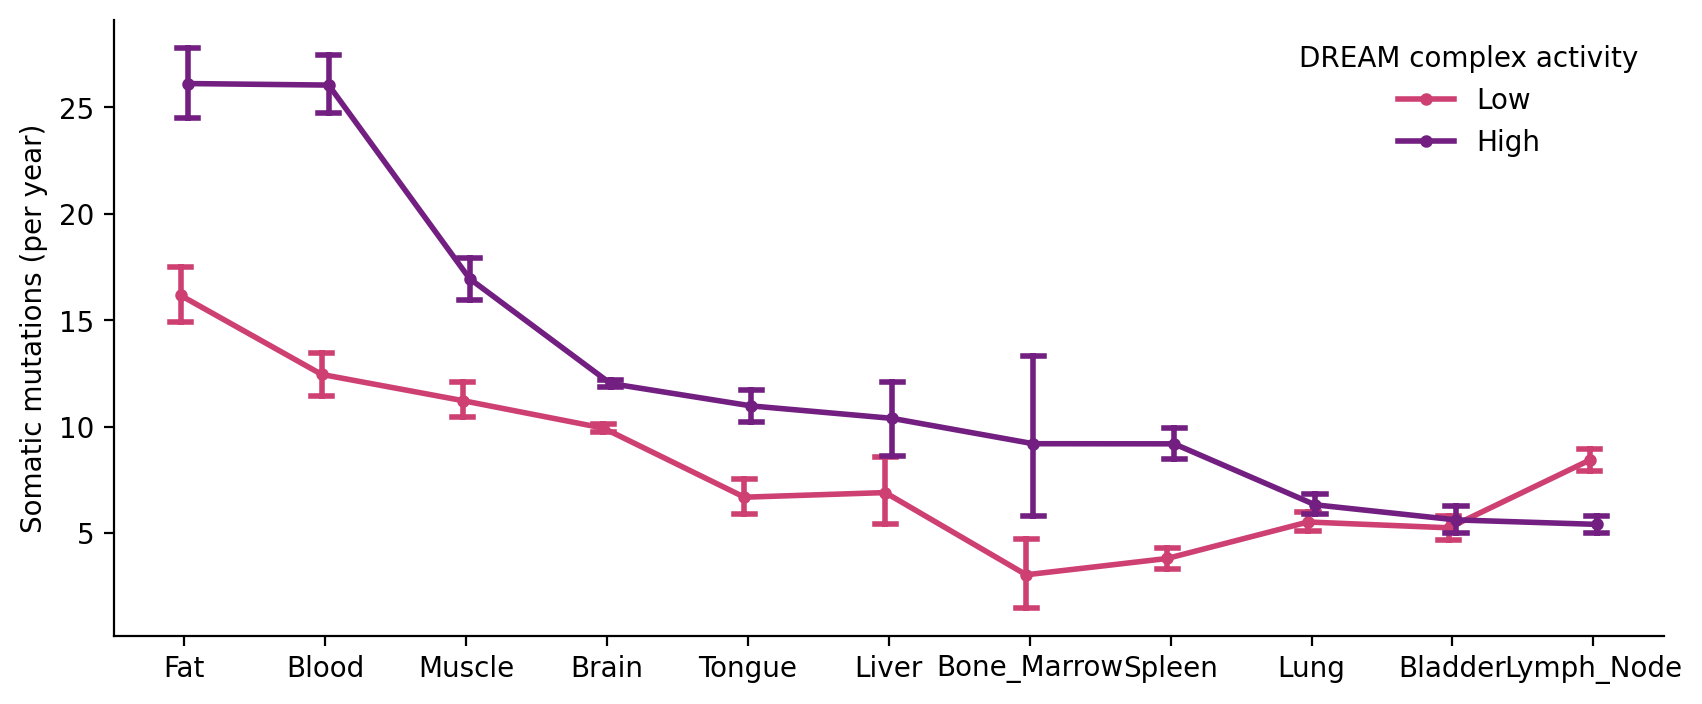

In [288]:
fig, axes = plt.subplots(figsize=(10,4))
mut_col = 'sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year'
dream_col = 'DREAM_normalized_enrichment_score_resid'

# ensure there are 3 samples per tissue and 1,000 cells per tissue
cells_per = ts_sea.dream_expression.obs.query("SitesPerCell >= 1e5").dropna(subset = [mut_col])['tissue'].value_counts()
samples_per = ts_sea.dream_expression.obs.query("SitesPerCell >= 1e5").dropna(subset = [mut_col]).groupby('tissue')['donor_id'].nunique().sort_values(ascending = False)
cells_per = cells_per[cells_per >= 500]
samples_per = samples_per[samples_per >= 2]
to_use = set(cells_per.index.tolist()) & set(samples_per.index.tolist())


# donors with enough cell types to be relevant
#donors_to_use = ['TSP1', 'TSP2', 'TSP7','TSP14'] #['TSP2','TSP14']#
subset = "SitesPerCell >= 1e5 and tissue in @to_use" #and donor_id in @donors_to_use"

# within each age, bin the mean_dream_activity into 3 bins
ts_sea.dream_expression.obs['dream_activity_bin'] = ts_sea.dream_expression.obs.query(subset).groupby(['tissue'])[dream_col].transform(
    lambda x: pd.qcut(x, 5, labels = ['Low', 'Low-Medium', 'Medium', 'Medium-High', 'High'])
    )

# order tissues by mean mutation burden in high dream
order = ts_sea.dream_expression.obs.query(subset).groupby(['tissue', 'dream_activity_bin'])[mut_col].mean().sort_values(
    ascending=False
    ).reset_index().query("dream_activity_bin == 'High'")['tissue']

sns.pointplot(
    data = ts_sea.dream_expression.obs.query(subset), y = mut_col, x = 'tissue',
    hue = 'dream_activity_bin', # showfliers = False,
    hue_order=['Low', 'High'], palette=[magma_categorical(5), magma_categorical(3)],
    ax = axes, order = order, errorbar = ('ci', 95), dodge=True, capsize=.15, 
    # make lines thinner
    linewidth = 2, markersize = 3, rasterized=True, 
    )
plt.xlabel('')
plt.ylabel('Somatic mutations (per year)')
# move legend off plot to the right
plt.legend(title='DREAM complex activity', frameon=False, loc='upper right')
# move y axis to the right
sns.despine()

# output to svg
#plt.savefig('/cellar/users/zkoch/dream/figures/fig1/mutation_burden_by_tissue_dream_activity_horizontal.svg', format='svg', dpi=300)

# for each tissue, test if the distribution of mutations in high dream is different than low dream
from scipy.stats import ttest_ind
pvals = []
for tissue in to_use:
    pval = ttest_ind(
            ts_sea.dream_expression.obs.query(subset).query('tissue == @tissue and dream_activity_bin == "High"').dropna(subset = ['age'])[mut_col], # need to drop the 3 brain samples with no age
            ts_sea.dream_expression.obs.query(subset).query('tissue == @tissue and dream_activity_bin == "Low"').dropna(subset = ['age'])[mut_col]
        ).pvalue
    pvals.append(pval)
# calculcate FDR pvalue
from statsmodels.stats.multitest import multipletests
fdr_pvals = multipletests(pvals, alpha = 0.05, method = 'fdr_bh')[1]
print(list(zip(to_use, fdr_pvals)))
# save as svg
plt.savefig('/cellar/users/zkoch/dream/figures/fig_human_mut/mutation_rate_by_tissue_dream_activity.svg', format='svg', dpi=300)

In [289]:
print(list(zip(to_use, fdr_pvals)))

[('Brain', np.float64(2.7114546149759216e-68)), ('Lung', np.float64(0.015720283515843887)), ('Tongue', np.float64(8.813830597148229e-14)), ('Lymph_Node', np.float64(2.929564638945103e-18)), ('Spleen', np.float64(6.517607952922498e-32)), ('Muscle', np.float64(6.5872712765897734e-18)), ('Bladder', np.float64(0.4208206879503461)), ('Bone_Marrow', np.float64(0.005818477046983373)), ('Blood', np.float64(2.728452882765539e-54)), ('Liver', np.float64(0.006100352945477232)), ('Fat', np.float64(9.594868926925452e-20))]


# Supp: Mutation rate in single cell types

/tmp/ipykernel_1503312/2024278633.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burden_df.dropna(subset=[mutation_column, age_column], inplace=True)


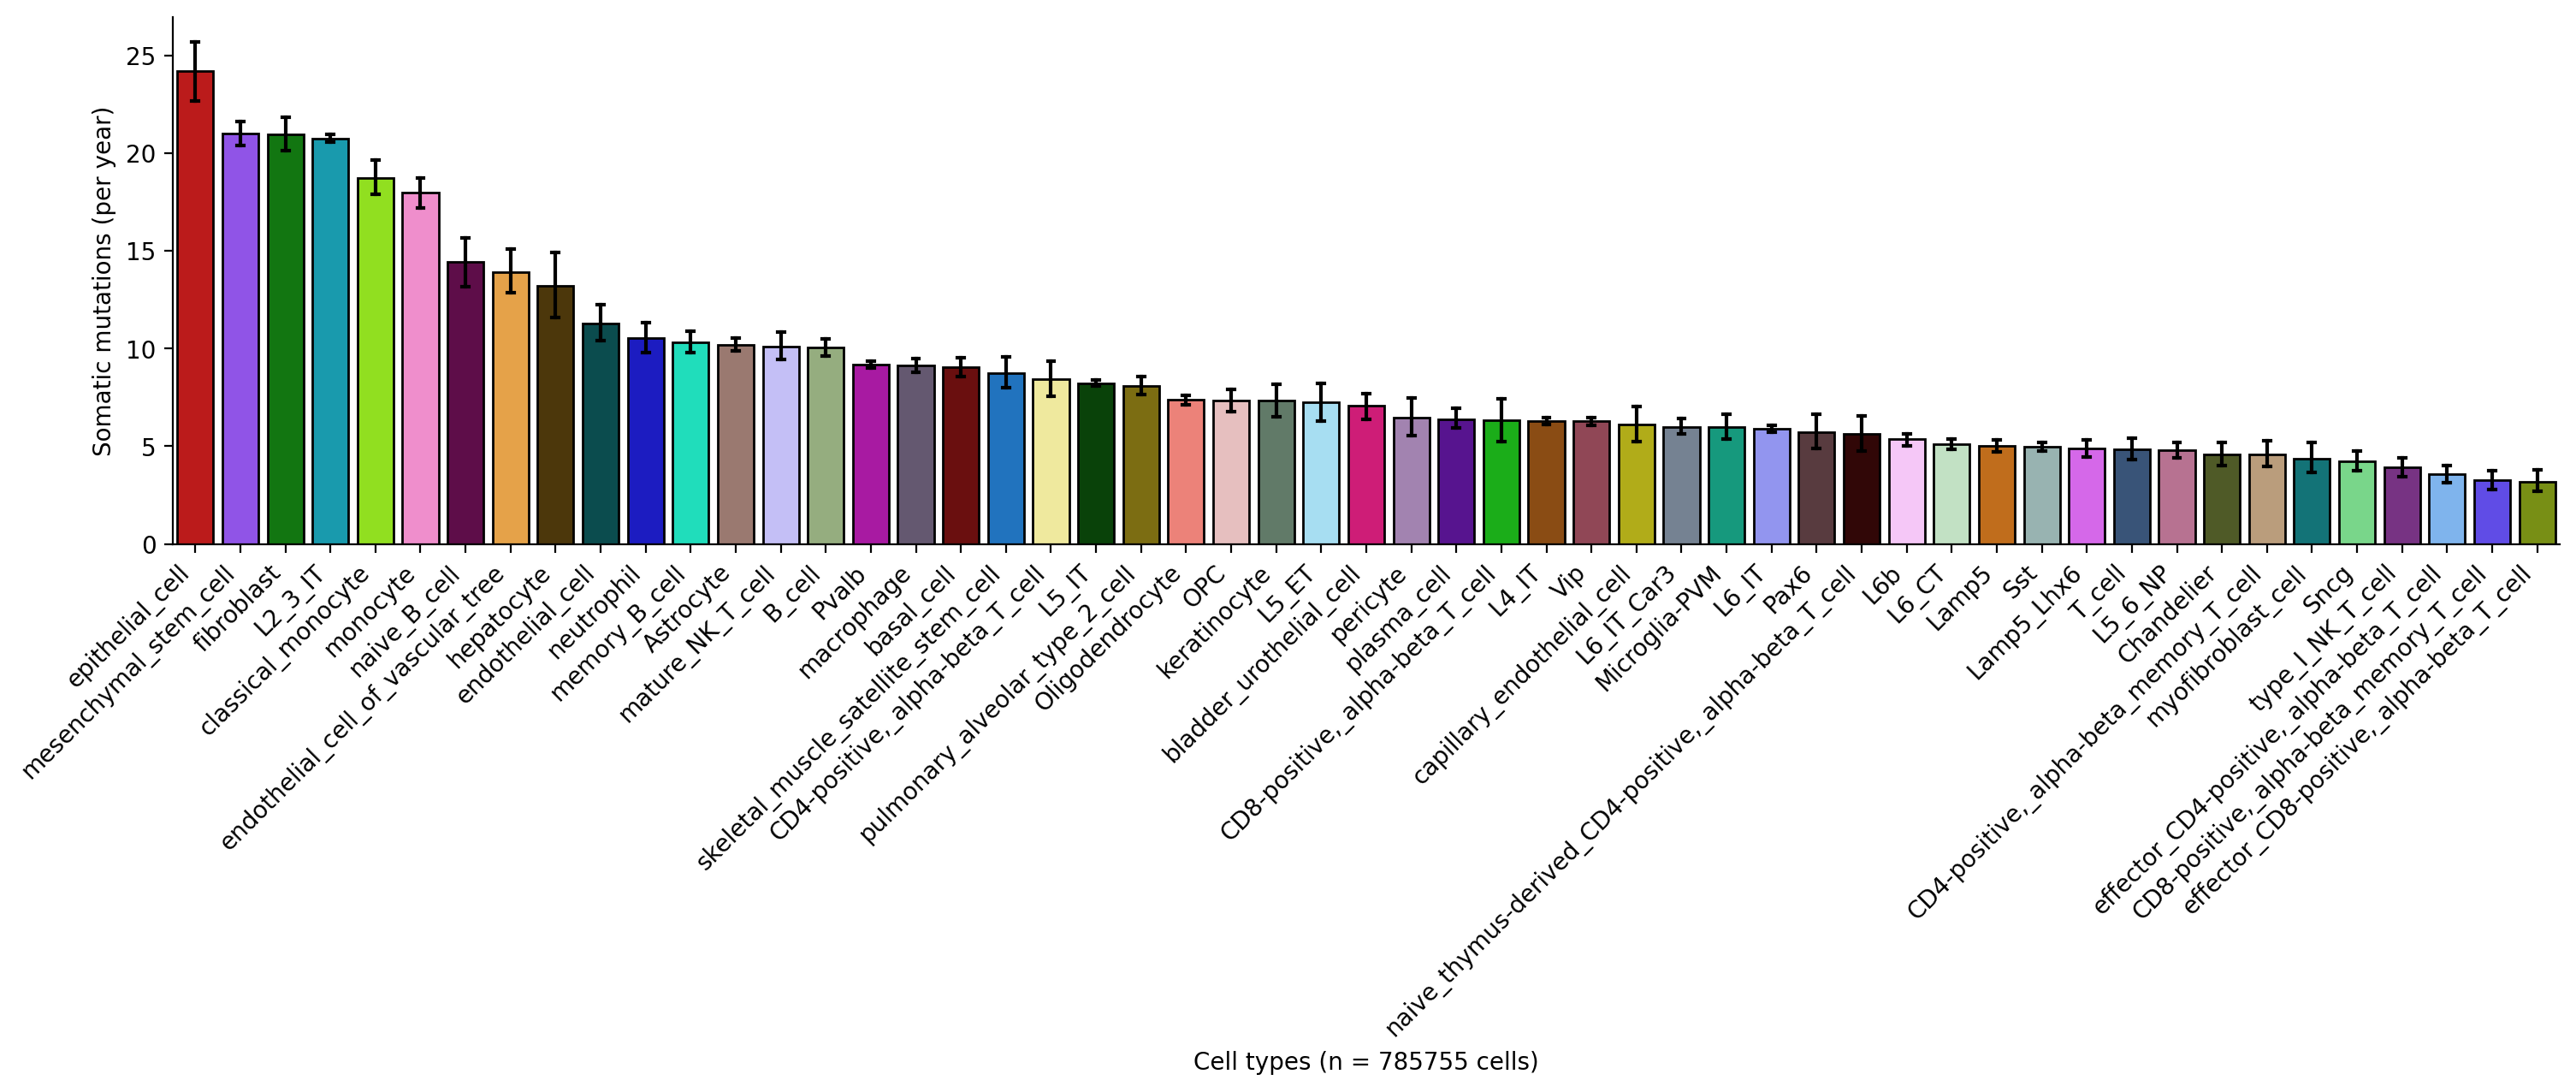

In [51]:
callable_sites_col = 'SitesPerCell'
mutation_column = 'sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year'
age_column = 'age'
cell_type_column = 'cell_type'
min_callable_sites = 1e5
min_cell_per_subclass = 100

burden_df = ts_sea.dream_expression.obs.query(f"{callable_sites_col} >= @min_callable_sites")
burden_df.dropna(subset=[mutation_column, age_column], inplace=True)

# Filter celltypes with too few cells
ct_counts = burden_df.query(f"{mutation_column} > 0")[cell_type_column].value_counts()
celltypes_to_keep = ct_counts[ct_counts >= min_cell_per_subclass].index
burden_df = burden_df.loc[burden_df[cell_type_column].isin(celltypes_to_keep)]

fig, axes = plt.subplots(1,1, figsize = (18,4))  
order = burden_df.groupby(cell_type_column)[mutation_column].mean().sort_values(ascending = False).index
# create palette mapping from tissue to cc.glasbey
# Create mapping from tissue to first len(tissues) colors from cc.glasbey
tissue_colors = {tissue: cc.glasbey[i] for i, tissue in enumerate(order)}

# switch Liver and Bone_Marrow
sns.barplot(
    data = burden_df, x = cell_type_column, y = mutation_column, order = order,
    ax = axes, capsize = 0.15, palette = tissue_colors,
    err_kws = {'color': 'black', 'linewidth': 1.5}, hue = cell_type_column, legend = False,
    edgecolor = 'black', errorbar = ('ci', 95)
    )
sns.despine()
axes.set_ylabel('Somatic mutations (per year)')
axes.set_xlabel(f'Cell types (n = {len(burden_df)} cells)')
# angle x labels
_ = plt.xticks(rotation=45, ha='right')

# save as svg
plt.savefig('/cellar/users/zkoch/dream/figures/supplementary/human_mut/mutation_burden_per_year_by_cell_type.svg', format='svg', dpi=300)

# Supp: comparison with previous mutation rate estimates

In [153]:
ren_data = pd.DataFrame({
    'ren_cell_type': ['Testis seminiferous tubule / not specified',
'Semen / sperm',
'Bile ductule / not specified',
'Leg muscle vastus lateralis / satellite cell',
'Bone marrow / blood progenitor',
'Pancreatic acini / not specified',
'Blood / naive B lymphocyte',
'Prefrontal cortex / Hippocampus / neuron',
'Prefrontal cortex / neuron',
'Prostate / prostate epithelium',
'Blood / hematopoictic stem and progenitor cell',
'Blood / memory B lymphocyte',
'Frontal cortex / neuron',
'Subcutancous adipose tissue / pro-adipocyte',
'Prostatic gland / not specified',
'Blood / granulocyte',
'Colon / Bladder / smooth muscle',
'Prefrontal cortex / Hippocampus / neuron',
'Blood / naive T lymphocyte',
'Lung / bronchial epithelium',
'Prefrontal cortex / neuron',
'Skin / skin fibroblast',
'Gastric gland / not specified',
'Blood / memory T lymphocyte',
'Blood / B lymphocyte',
'Visceral adipose tissue / pre-adipocyte',
'Lung / proximal bronchial basal cell',
'Utcrine / endometrial epithelium',
'Liver / hepatocyte',
'Liver / adult stem cell',
'Small intestine / adult stem cell',
'Colon / adult stem cell',
'Bladder / urothelium',
'Skin / ocsophageal epithelium',
'Colon / crypt',
'Colorectal / crypt',
'Small intestine / crypt',
'Colon / crypt',
'Liver / hepatocyte',
'Appendix intestine / crypt'
], 'ren_mutation_rate' : [2.4, 2.5, 9,13,14,15,15,15,16,16,16,17,17,18,19,20,21,21,22,22,23,24,25,25,25,27,28,29,33,36,36,36,41,42,44,47,49,51,52,56]
})

ren_to_cell_type_mapping = {
    'Testis seminiferous tubule / not specified': [],
    'Semen / sperm': [],
    'Bile ductule / not specified': [],
    'Leg muscle vastus lateralis / satellite cell': ['skeletal_muscle_satellite_stem_cell'],
    'Bone marrow / blood progenitor': ['macrophage', 'classical_monocyte'],
    'Pancreatic acini / not specified': [],
    'Blood / naive B lymphocyte': ['naive_B_cell'],
    'Prefrontal cortex / Hippocampus / neuron': [],
    'Prefrontal cortex / neuron': ['L2_3_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L5_6_NP', 'L6_CT', 'L6b', 'L6_IT_Car3', 'L5_ET', 'Pvalb', 'Sst', 'Vip', 'Sncg', 'Lamp5', 'Lamp5_Lhx6', 'Pax6','Chandelier', ],
    'Prostate / prostate epithelium': ['epithelial_cell'],
    'Blood / hematopoictic stem and progenitor cell': [],
    'Blood / memory B lymphocyte': ['memory_B_cell'],
    'Frontal cortex / neuron': [],
    'Subcutancous adipose tissue / pro-adipocyte': ['mesenchymal_stem_cell'],
    'Prostatic gland / not specified': [],
    'Blood / granulocyte': ['neutrophil'],
    'Colon / Bladder / smooth muscle': [],
    'Blood / naive T lymphocyte': ['naive_thymus-derived_CD4-positive,_alpha-beta_T_cell'],
    'Lung / bronchial epithelium': ['basal_cell'],
    'Skin / skin fibroblast': ['fibroblast'],
    'Gastric gland / not specified': [],
    'Blood / memory T lymphocyte': ['CD4-positive,_alpha-beta_memory_T_cell'],
    'Blood / B lymphocyte': ['B_cell'],
    'Visceral adipose tissue / pre-adipocyte': [],
    'Lung / proximal bronchial basal cell': [],
    'Utcrine / endometrial epithelium': [],
    'Liver / hepatocyte': [],
    'Liver / adult stem cell': [],
    'Small intestine / adult stem cell': [],
    'Colon / adult stem cell': [],
    'Bladder / urothelium': ['bladder_urothelial_cell'],
    'Skin / ocsophageal epithelium': [],
    'Colon / crypt': [],
    'Colorectal / crypt': [],
    'Small intestine / crypt': [],
    'Appendix intestine / crypt': []
}
ren_data['cell_type'] = ren_data['ren_cell_type'].map(ren_to_cell_type_mapping)

scomatic_means = burden_df.groupby('cell_type')[mutation_column].mean()


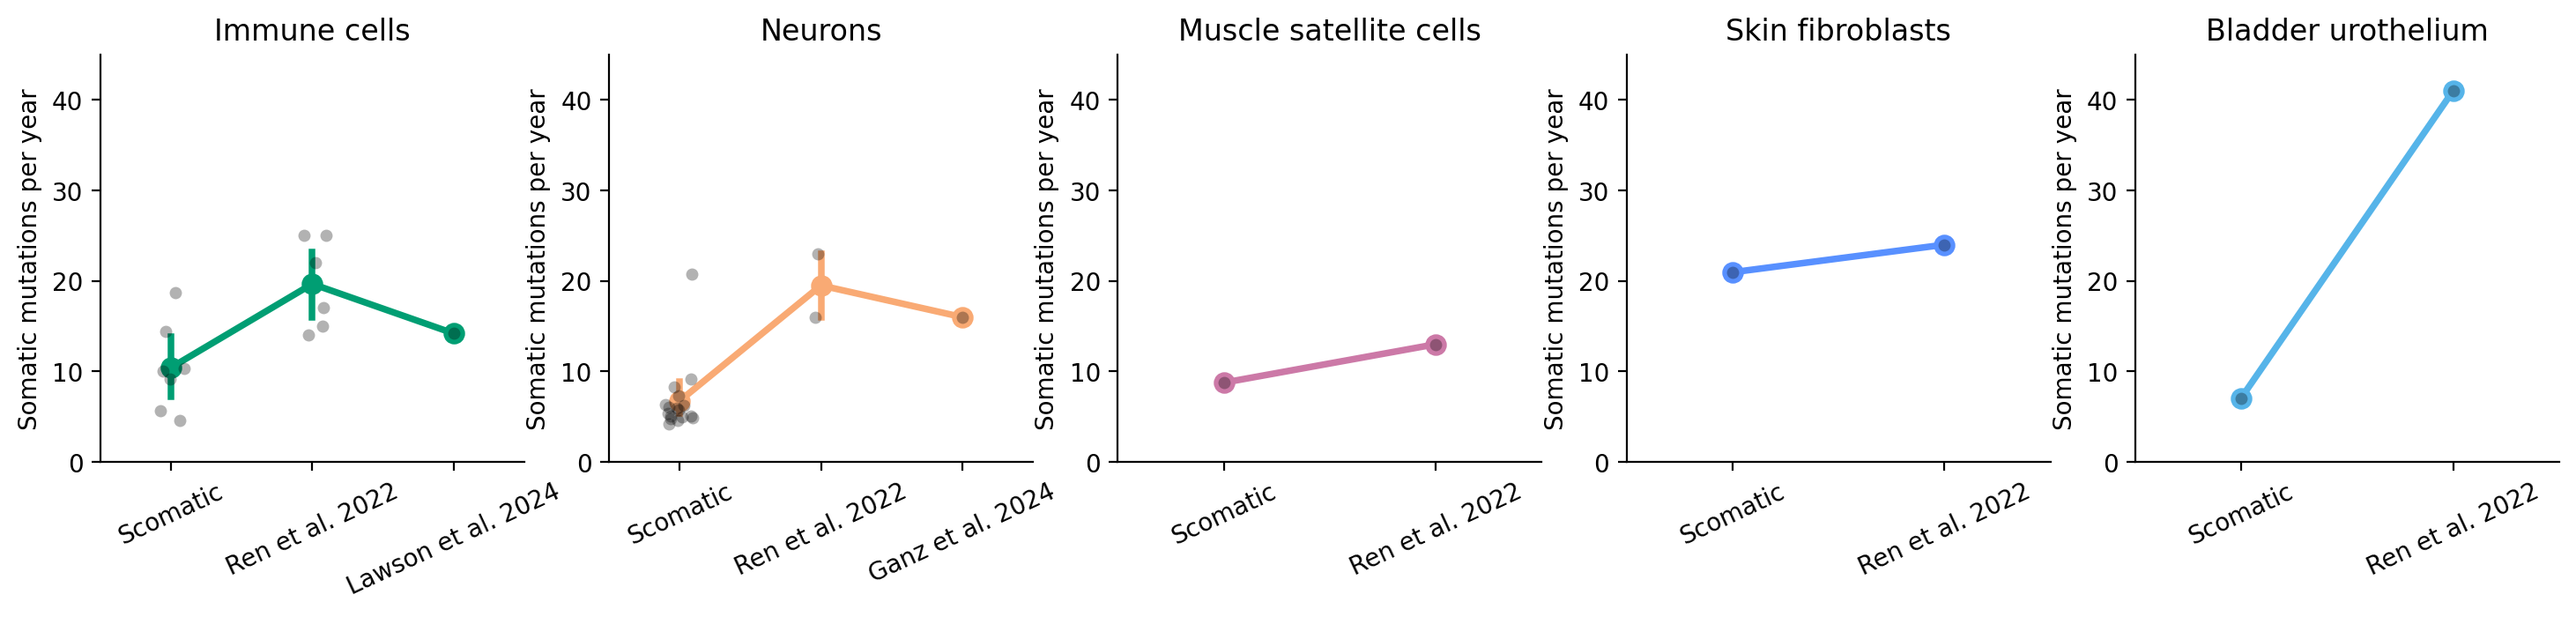

In [176]:
fig, axes = plt.subplots(1,5, figsize = (18, 3), sharey = False)
axes = axes.flatten()

# immune cells

# 'Blood / naive B lymphocyte'
naive_b_cells = ren_data.query(" ren_cell_type == 'Blood / naive B lymphocyte'")
naive_b_cells_exploded = naive_b_cells.explode('cell_type').reset_index(drop = True)
naive_b_cells_exploded['mutation_rate'] = naive_b_cells_exploded['cell_type'].map(scomatic_means)
scomatic_naive_b_cell_rates = scomatic_means.loc[naive_b_cells_exploded['cell_type']].to_frame().rename(columns = {'sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year': 'mutation_rate'})
scomatic_naive_b_cell_rates['source'] = 'Scomatic'
ren_naive_b_cell_rates = naive_b_cells['ren_mutation_rate'].to_frame().rename(columns = {'ren_mutation_rate': 'mutation_rate'})
ren_naive_b_cell_rates['source'] = 'Ren et al. 2022'
naive_b_cell_mutation_rates = pd.concat([scomatic_naive_b_cell_rates, ren_naive_b_cell_rates])
# 'Blood / memory B lymphocyte'
memory_b_cells = ren_data.query("ren_cell_type == 'Blood / memory B lymphocyte'")
memory_b_cells_exploded = memory_b_cells.explode('cell_type').reset_index(drop = True)
memory_b_cells_exploded['mutation_rate'] = memory_b_cells_exploded['cell_type'].map(scomatic_means)
scomatic_memory_b_cell_rates = scomatic_means.loc[memory_b_cells_exploded['cell_type']].to_frame().rename(columns = {'sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year': 'mutation_rate'})
scomatic_memory_b_cell_rates['source'] = 'Scomatic'
ren_memory_b_cell_rates = memory_b_cells['ren_mutation_rate'].to_frame().rename(columns = {'ren_mutation_rate': 'mutation_rate'})
ren_memory_b_cell_rates['source'] = 'Ren et al. 2022'
memory_b_cell_mutation_rates = pd.concat([scomatic_memory_b_cell_rates, ren_memory_b_cell_rates])
#  'Blood / naive T lymphocyte'
naive_t_cells = ren_data.query("ren_cell_type == 'Blood / naive T lymphocyte'")
naive_t_cells_exploded = naive_t_cells.explode('cell_type').reset_index(drop = True)
naive_t_cells_exploded['mutation_rate'] = naive_t_cells_exploded['cell_type'].map(scomatic_means)
scomatic_naive_t_cell_rates = scomatic_means.loc[naive_t_cells_exploded['cell_type']].to_frame().rename(columns = {'sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year': 'mutation_rate'})
scomatic_naive_t_cell_rates['source'] = 'Scomatic'
ren_naive_t_cell_rates = naive_t_cells['ren_mutation_rate'].to_frame().rename(columns = {'ren_mutation_rate': 'mutation_rate'})
ren_naive_t_cell_rates['source'] = 'Ren et al. 2022'
naive_t_cell_mutation_rates = pd.concat([scomatic_naive_t_cell_rates, ren_naive_t_cell_rates])
# 'Blood / memory T lymphocyte'
memory_t_cells = ren_data.query("ren_cell_type == 'Blood / memory T lymphocyte'")
memory_t_cells_exploded = memory_t_cells.explode('cell_type').reset_index(drop = True)
memory_t_cells_exploded['mutation_rate'] = memory_t_cells_exploded['cell_type'].map(scomatic_means)
scomatic_memory_t_cell_rates = scomatic_means.loc[memory_t_cells_exploded['cell_type']].to_frame().rename(columns = {'sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year': 'mutation_rate'})
scomatic_memory_t_cell_rates['source'] = 'Scomatic'
ren_memory_t_cell_rates = memory_t_cells['ren_mutation_rate'].to_frame().rename(columns = {'ren_mutation_rate': 'mutation_rate'})
ren_memory_t_cell_rates['source'] = 'Ren et al. 2022'
memory_t_cell_mutation_rates = pd.concat([scomatic_memory_t_cell_rates, ren_memory_t_cell_rates])
# 'Blood / B lymphocyte'
b_cells = ren_data.query("ren_cell_type == 'Blood / B lymphocyte'")
b_cells_exploded = b_cells.explode('cell_type').reset_index(drop = True)
b_cells_exploded['mutation_rate'] = b_cells_exploded['cell_type'].map(scomatic_means)
scomatic_b_cell_rates = scomatic_means.loc[b_cells_exploded['cell_type']].to_frame().rename(columns = {'sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year': 'mutation_rate'})
scomatic_b_cell_rates['source'] = 'Scomatic'
ren_b_cell_rates = b_cells['ren_mutation_rate'].to_frame().rename(columns = {'ren_mutation_rate': 'mutation_rate'})
ren_b_cell_rates['source'] = 'Ren et al. 2022'
b_cell_mutation_rates = pd.concat([scomatic_b_cell_rates, ren_b_cell_rates])
# 'Bone marrow / blood progenitor'
blood_progenitors = ren_data.query("ren_cell_type == 'Bone marrow / blood progenitor'")
blood_progenitors_exploded = blood_progenitors.explode('cell_type').reset_index(drop = True)
blood_progenitors_exploded['mutation_rate'] = blood_progenitors_exploded['cell_type'].map(scomatic_means)
scomatic_blood_progenitors_rates = scomatic_means.loc[blood_progenitors_exploded['cell_type']].to_frame().rename(columns = {'sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year': 'mutation_rate'})
scomatic_blood_progenitors_rates['source'] = 'Scomatic'
ren_blood_progenitors_rates = blood_progenitors['ren_mutation_rate'].to_frame().rename(columns = {'ren_mutation_rate': 'mutation_rate'})
ren_blood_progenitors_rates['source'] = 'Ren et al. 2022'
blood_progenitors_mutation_rates = pd.concat([scomatic_blood_progenitors_rates, ren_blood_progenitors_rates])
# lawson
blood_progenitors_mutation_rates.loc['neuron'] = [14.2, 'Lawson et al. 2024']
# combine all immune cell dfs
immune_mutation_rates = pd.concat([naive_b_cell_mutation_rates, memory_b_cell_mutation_rates, naive_t_cell_mutation_rates, memory_t_cell_mutation_rates, b_cell_mutation_rates, blood_progenitors_mutation_rates])
sns.stripplot(data = immune_mutation_rates, x = 'source', y = 'mutation_rate', color = 'black', alpha = 0.3, ax = axes[0])
sns.pointplot(data = immune_mutation_rates, x = 'source', y = 'mutation_rate', ax = axes[0], color = my_categorical_palette[0])
axes[0].set_ylabel('Somatic mutations per year')
axes[0].set_title('Immune cells')
axes[0].set_xlabel('')
sns.despine(ax = axes[0])

# neurons
neurons = ren_data.query(" ren_cell_type == 'Prefrontal cortex / neuron'")
neurons_exploded = neurons.explode('cell_type').reset_index(drop = True)
neurons_exploded['mutation_rate'] = neurons_exploded['cell_type'].map(scomatic_means)
scomatic_neuron_rates = scomatic_means.loc[neurons_exploded['cell_type']].to_frame().rename(columns = {'sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year': 'mutation_rate'})
# cut out duplicated second half
scomatic_neuron_rates = scomatic_neuron_rates.iloc[:17]
scomatic_neuron_rates['source'] = 'Scomatic'
ren_neuron_rates = neurons['ren_mutation_rate'].to_frame().rename(columns = {'ren_mutation_rate': 'mutation_rate'})
ren_neuron_rates['source'] = 'Ren et al. 2022'
neuron_mutation_rates = pd.concat([scomatic_neuron_rates, ren_neuron_rates])
neuron_mutation_rates.loc['neuron'] = [16, 'Ganz et al. 2024']
sns.stripplot(data = neuron_mutation_rates, x = 'source', y = 'mutation_rate', color = 'black', alpha = 0.3, ax = axes[1])
sns.pointplot(data = neuron_mutation_rates, x = 'source', y = 'mutation_rate',  ax = axes[1], color = my_categorical_palette[1])
axes[1].set_ylabel('Somatic mutations per year')
axes[1].set_title('Neurons')
axes[1].set_xlabel('')
sns.despine(ax = axes[1])

# muscle satellite cells
satellites = ren_data.query(" ren_cell_type == 'Leg muscle vastus lateralis / satellite cell'")
satellites_exploded = satellites.explode('cell_type').reset_index(drop = True)
satellites_exploded['mutation_rate'] = satellites_exploded['cell_type'].map(scomatic_means)
scomatic_satellite_rates = scomatic_means.loc[satellites_exploded['cell_type']].to_frame().rename(columns = {'sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year': 'mutation_rate'})
scomatic_satellite_rates['source'] = 'Scomatic'
ren_satellite_rates = satellites['ren_mutation_rate'].to_frame().rename(columns = {'ren_mutation_rate': 'mutation_rate'})
ren_satellite_rates['source'] = 'Ren et al. 2022'
satellite_mutation_rates = pd.concat([scomatic_satellite_rates, ren_satellite_rates])
sns.stripplot(data = satellite_mutation_rates, x = 'source', y = 'mutation_rate', color = 'black', alpha = 0.3, ax = axes[2])
sns.pointplot(data = satellite_mutation_rates, x = 'source', y = 'mutation_rate',ax = axes[2], color = my_categorical_palette[2])
axes[2].set_ylabel('Somatic mutations per year')
axes[2].set_title('Muscle satellite cells')
axes[2].set_xlabel('')
sns.despine(ax = axes[2])


# 'Skin / skin fibroblast'
fibroblasts = ren_data.query("ren_cell_type == 'Skin / skin fibroblast'")
fibroblasts_exploded = fibroblasts.explode('cell_type').reset_index(drop = True)
fibroblasts_exploded['mutation_rate'] = fibroblasts_exploded['cell_type'].map(scomatic_means)
scomatic_fibroblast_rates = scomatic_means.loc[fibroblasts_exploded['cell_type']].to_frame().rename(columns = {'sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year': 'mutation_rate'})
scomatic_fibroblast_rates['source'] = 'Scomatic'
ren_fibroblast_rates = fibroblasts['ren_mutation_rate'].to_frame().rename(columns = {'ren_mutation_rate': 'mutation_rate'})
ren_fibroblast_rates['source'] = 'Ren et al. 2022'
fibroblast_mutation_rates = pd.concat([scomatic_fibroblast_rates, ren_fibroblast_rates])
sns.stripplot(data = fibroblast_mutation_rates, x = 'source', y = 'mutation_rate', color = 'black', alpha = 0.3, ax = axes[3])
sns.pointplot(data = fibroblast_mutation_rates, x = 'source', y = 'mutation_rate', ax = axes[3], color = my_categorical_palette[3])
axes[3].set_ylabel('Somatic mutations per year')
axes[3].set_title('Skin fibroblasts')
axes[3].set_xlabel('')
sns.despine(ax = axes[3])


# 'Bladder / urothelium'
urothelium = ren_data.query("ren_cell_type == 'Bladder / urothelium'")
urothelium_exploded = urothelium.explode('cell_type').reset_index(drop = True)
urothelium_exploded['mutation_rate'] = urothelium_exploded['cell_type'].map(scomatic_means)
scomatic_urothelium_rates = scomatic_means.loc[urothelium_exploded['cell_type']].to_frame().rename(columns = {'sc_mutation_burden_in_bulk_per_genome_nanfilled_per_year': 'mutation_rate'})
scomatic_urothelium_rates['source'] = 'Scomatic'
ren_urothelium_rates = urothelium['ren_mutation_rate'].to_frame().rename(columns = {'ren_mutation_rate': 'mutation_rate'})
ren_urothelium_rates['source'] = 'Ren et al. 2022'
urothelium_mutation_rates = pd.concat([scomatic_urothelium_rates, ren_urothelium_rates])
sns.stripplot(data = urothelium_mutation_rates, x = 'source', y = 'mutation_rate', color = 'black', alpha = 0.3, ax = axes[4])
sns.pointplot(data = urothelium_mutation_rates, x = 'source', y = 'mutation_rate', ax = axes[4], color = my_categorical_palette[4])
axes[4].set_ylabel('Somatic mutations per year')
axes[4].set_title('Bladder urothelium')
axes[4].set_xlabel('')
sns.despine(ax = axes[4])

# set the bottom of all axes to 0
for ax in axes:
    ax.set_ylim(bottom = 0, top = 45)
    # angle x tick labels
    ax.tick_params(axis='x', rotation=25)
    
# save as svg
fig.savefig('/cellar/users/zkoch/dream/figures/supplementary/human_mut/literature_mutation_rates.svg', format='svg', dpi=300)

# G) DREAM vs. AD 

In [26]:
import ad_risk_models  
import statsmodels.api as sm
# the neurotypical reference samples do not have reported ages, so fill them with the mean age of the dataset
dataset_mean = sea_ad.adata.obs.groupby('donor_id')['age'].mean().mean()
sea_ad.dream_expression.obs.loc[sea_ad.dream_expression.obs['Neurotypical reference'] == 'True', 'age'] = dataset_mean

In [27]:
# create regression df

# remove cell types with fewer than 1000 cells
sea_ad.dream_expression.obs['n_cells_per_subclass'] = sea_ad.dream_expression.obs.groupby('cell_type')['mutation_burden_per_kb'].transform('count')
# make the regression df, which has variables: 
sea_ad_reg_df = ad_risk_models.make_regr_df(
    sea_ad.dream_expression.obs,
    )
# filter out cells with fewer than 1e5 callable sites
sea_ad_reg_df.query("SitesPerCell > 1e5", inplace=True)
# make sure the cell had mutations observed
sea_ad_reg_df.dropna(subset = ['sc_mutation_burden_in_bulk_per_genome_nanfilled'], inplace=True)
# drop subclasses with fewer than 100 cells
subclass_counts = sea_ad_reg_df['cell_type'].value_counts()
subclasses_to_keep = subclass_counts[subclass_counts >= 100].index
sea_ad_reg_df = sea_ad_reg_df.loc[sea_ad_reg_df['cell_type'].isin(subclasses_to_keep)]
# drop neurotypical reference samples because they have no age
sea_ad_reg_df = sea_ad_reg_df.query("neurotypical_reference == 0")

/cellar/users/zkoch/miniconda3/envs/dream_proj_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cellar/users/zkoch/miniconda3/envs/dream_proj_env/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


### G): neuropathological variables

/tmp/ipykernel_1756058/3453933447.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels([mapper[tick.get_text()] for tick in axes.get_yticklabels()])
/tmp/ipykernel_1756058/3453933447.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels([mapper[tick.get_text()] for tick in axes.get_yticklabels()])


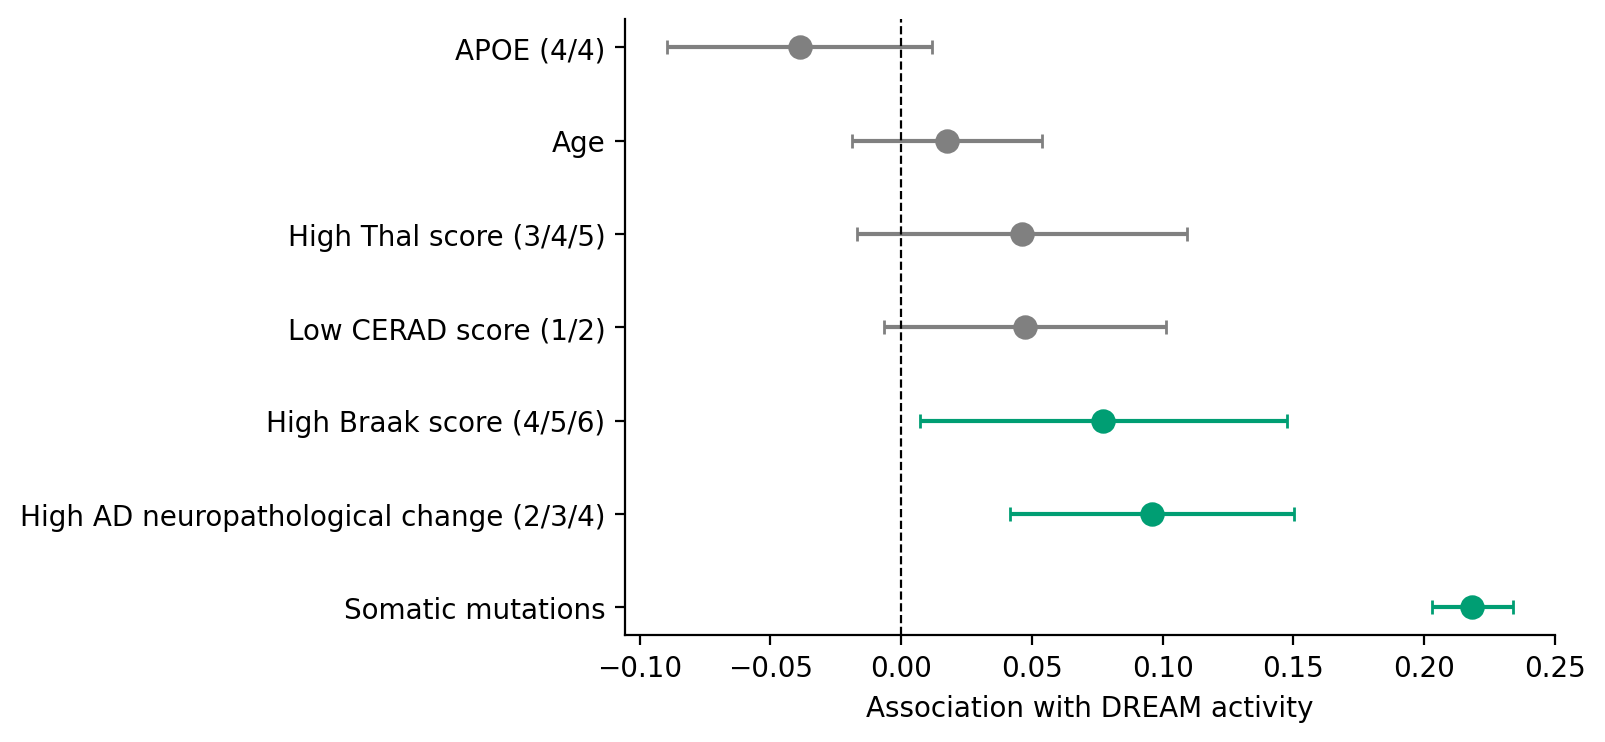

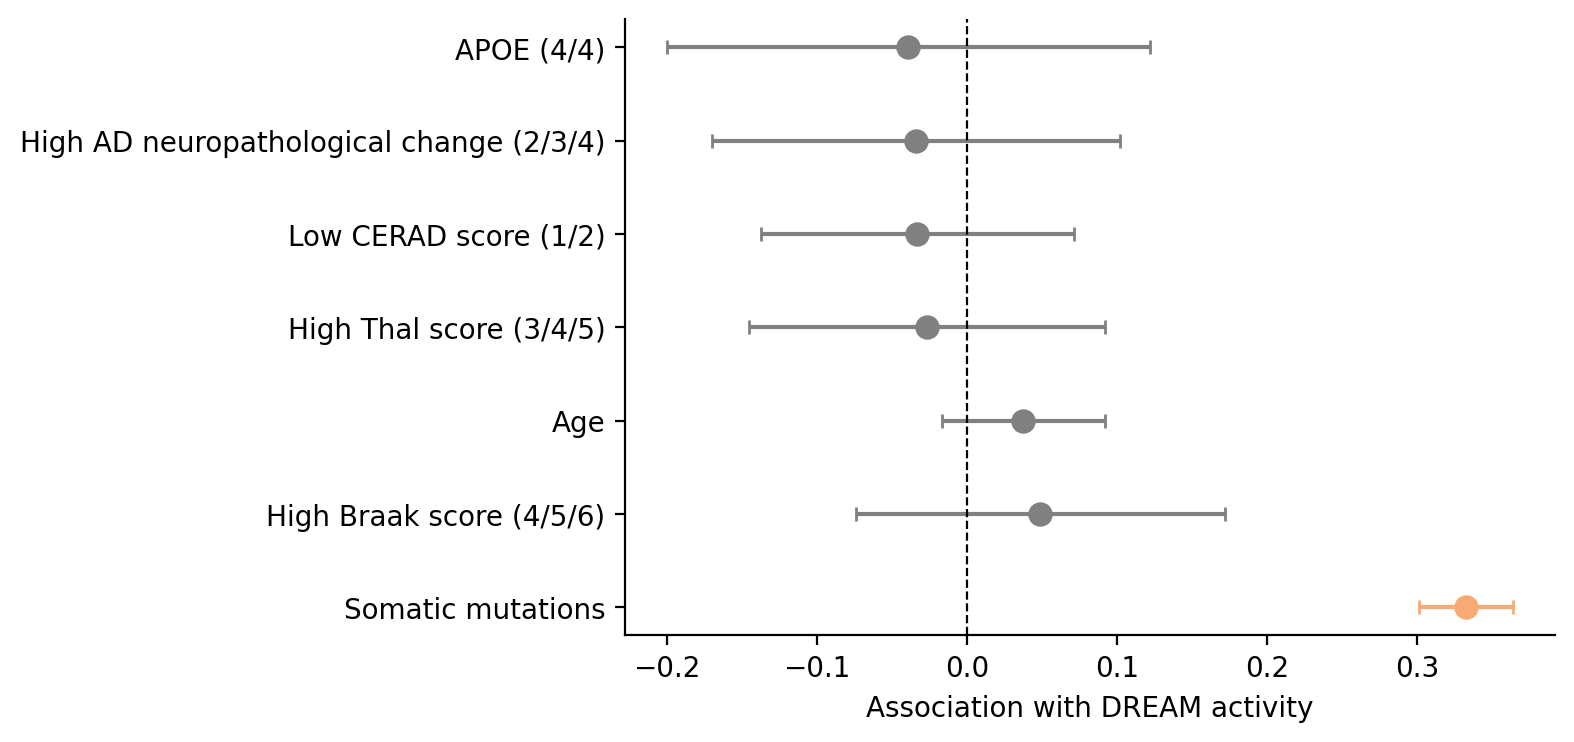

In [97]:
# each variable one by one

fig, axes = plt.subplots(1, 1, figsize = (6, 4))

target = 'DREAM_normalized_enrichment_score_resid'
variables = ['age_death_rescaled', 'log_sc_mutation_burden_in_bulk_per_genome', 'adnc234',  'braak456', 'cerad12', 'thal345', 'apoe44']
offset_str = 'log_n_genes' 

# with age correction, with hierarchy correction
coef_df = ad_risk_models.do_regr_one_by_one(
    sea_ad_reg_df.query("lineage == 'Neuronal'"),
    target = target,
    variables = variables,
    count_vars = [], 
    ext_covars = [],
    offset = True,
    offset_str = offset_str,
    correct_hierarchy = True,
    family=sm.families.Gaussian()
)
# create a grey version of my_categorical_palette[0] for the not significant coefficient
ad_risk_models.plot_coefficients(coef_df = coef_df, ax = axes, colors = ['grey', my_categorical_palette[0]])
# rename y ticklabels
mapper = {
    'age_death_rescaled': 'Age',
    'log_sc_mutation_burden_in_bulk_per_genome': 'Somatic mutations',
    'adnc234': 'High AD neuropathological change (2/3/4)',
    'braak456': 'High Braak score (4/5/6)',
    'cerad12': 'Low CERAD score (1/2)',
    'thal345': 'High Thal score (3/4/5)',
    'apoe44': 'APOE (4/4)'
}
axes.set_yticklabels([mapper[tick.get_text()] for tick in axes.get_yticklabels()])
axes.set_xlabel('Association with DREAM activity')
axes.set_ylabel('')
# save as svg
fig.savefig('/cellar/users/zkoch/dream/figures/fig_human_mut/AD_risk_neuron_coefs.svg', bbox_inches = 'tight')

fig, axes = plt.subplots(1, 1, figsize = (6, 4))
coef_df2 = ad_risk_models.do_regr_one_by_one(
    sea_ad_reg_df.query("lineage == 'Glial'"),
    target = target,
    variables = variables,
    count_vars = [], 
    ext_covars = [],
    offset = True,
    offset_str = offset_str,
    correct_hierarchy = True,
    family=sm.families.Gaussian()
)
ad_risk_models.plot_coefficients(coef_df = coef_df2, ax = axes, colors = ['grey', my_categorical_palette[1]])
axes.set_yticklabels([mapper[tick.get_text()] for tick in axes.get_yticklabels()])
axes.set_xlabel('Association with DREAM activity')
axes.set_ylabel('')
# save to svg
fig.savefig('/cellar/users/zkoch/dream/figures/supplementary/human_mut/AD_risk_glial_coefs.svg', bbox_inches = 'tight')
